## Importing the required libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from collections import Counter


from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


import lightgbm as lgb
import xgboost as xgb
import catboost as cb

## Style 

In [2]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Loading data 

In [7]:
import pandas as pd
df = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

print(df.shape, test.shape)

(517754, 14) (172585, 13)


In [8]:
print("columns at the train data : " + str(df.columns))

columns at the train data : Index(['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents', 'accident_risk'],
      dtype='object')


In [9]:
print("columns at test data : " + str(test.columns))

columns at test data : Index(['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents'],
      dtype='object')


In [10]:
df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [11]:
test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [12]:
# dropping id columns from train and test data

df = df.drop(columns=["id"])
test = test.drop(columns=["id"])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 37.5+ MB


In [14]:
df.describe()

,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,2.491511,0.488719,46.112575,1.187970,0.352377
std,1.120434,0.272563,15.788521,0.895961,0.166417
min,1.000000,0.000000,25.000000,0.000000,0.000000
25%,1.000000,0.260000,35.000000,1.000000,0.230000
50%,2.000000,0.510000,45.000000,1.000000,0.340000
75%,3.000000,0.710000,60.000000,2.000000,0.460000
max,4.000000,1.000000,70.000000,7.000000,1.000000


In [15]:
df.describe(include = object)

,road_type,lighting,weather,time_of_day
count,517754,517754,517754,517754
unique,3,3,3,3
top,highway,dim,foggy,morning
freq,173672,183826,181463,173410


In [16]:
df.isna().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [17]:
test.isna().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
dtype: int64

In [18]:
df.duplicated().sum()

np.int64(656)

In [19]:
#drop duplicates rows 
df = df.drop_duplicates()

#check for missing values
df.isnull().sum()

road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [20]:
# numerical columns train 
num_cols_train = df.select_dtypes(include=[np.number]).columns.tolist()
print("numerical columns:", num_cols_train)

numerical columns: ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents', 'accident_risk']


In [21]:
# categorical columns train 
cat_cols_train = df.select_dtypes(exclude = np.number).columns.tolist()
print(cat_cols_train)

['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']


In [22]:
# function to count the categories in a column
def count_categories(df, column):
    return df[column].value_counts()


for col in cat_cols_train:
    print(count_categories(df, col))
    print("\n")

road_type
highway    173452
rural      172504
urban      171142
Name: count, dtype: int64


lighting
dim         183601
daylight    177746
night       155751
Name: count, dtype: int64


weather
foggy    181254
clear    179055
rainy    156789
Name: count, dtype: int64


road_signs_present
False    258961
True     258137
Name: count, dtype: int64


public_road
True     259712
False    257386
Name: count, dtype: int64


time_of_day
morning      173196
evening      172615
afternoon    171287
Name: count, dtype: int64


holiday
True     260352
False    256746
Name: count, dtype: int64


school_season
False    259817
True     257281
Name: count, dtype: int64




## EDA

### Univariate Analysis

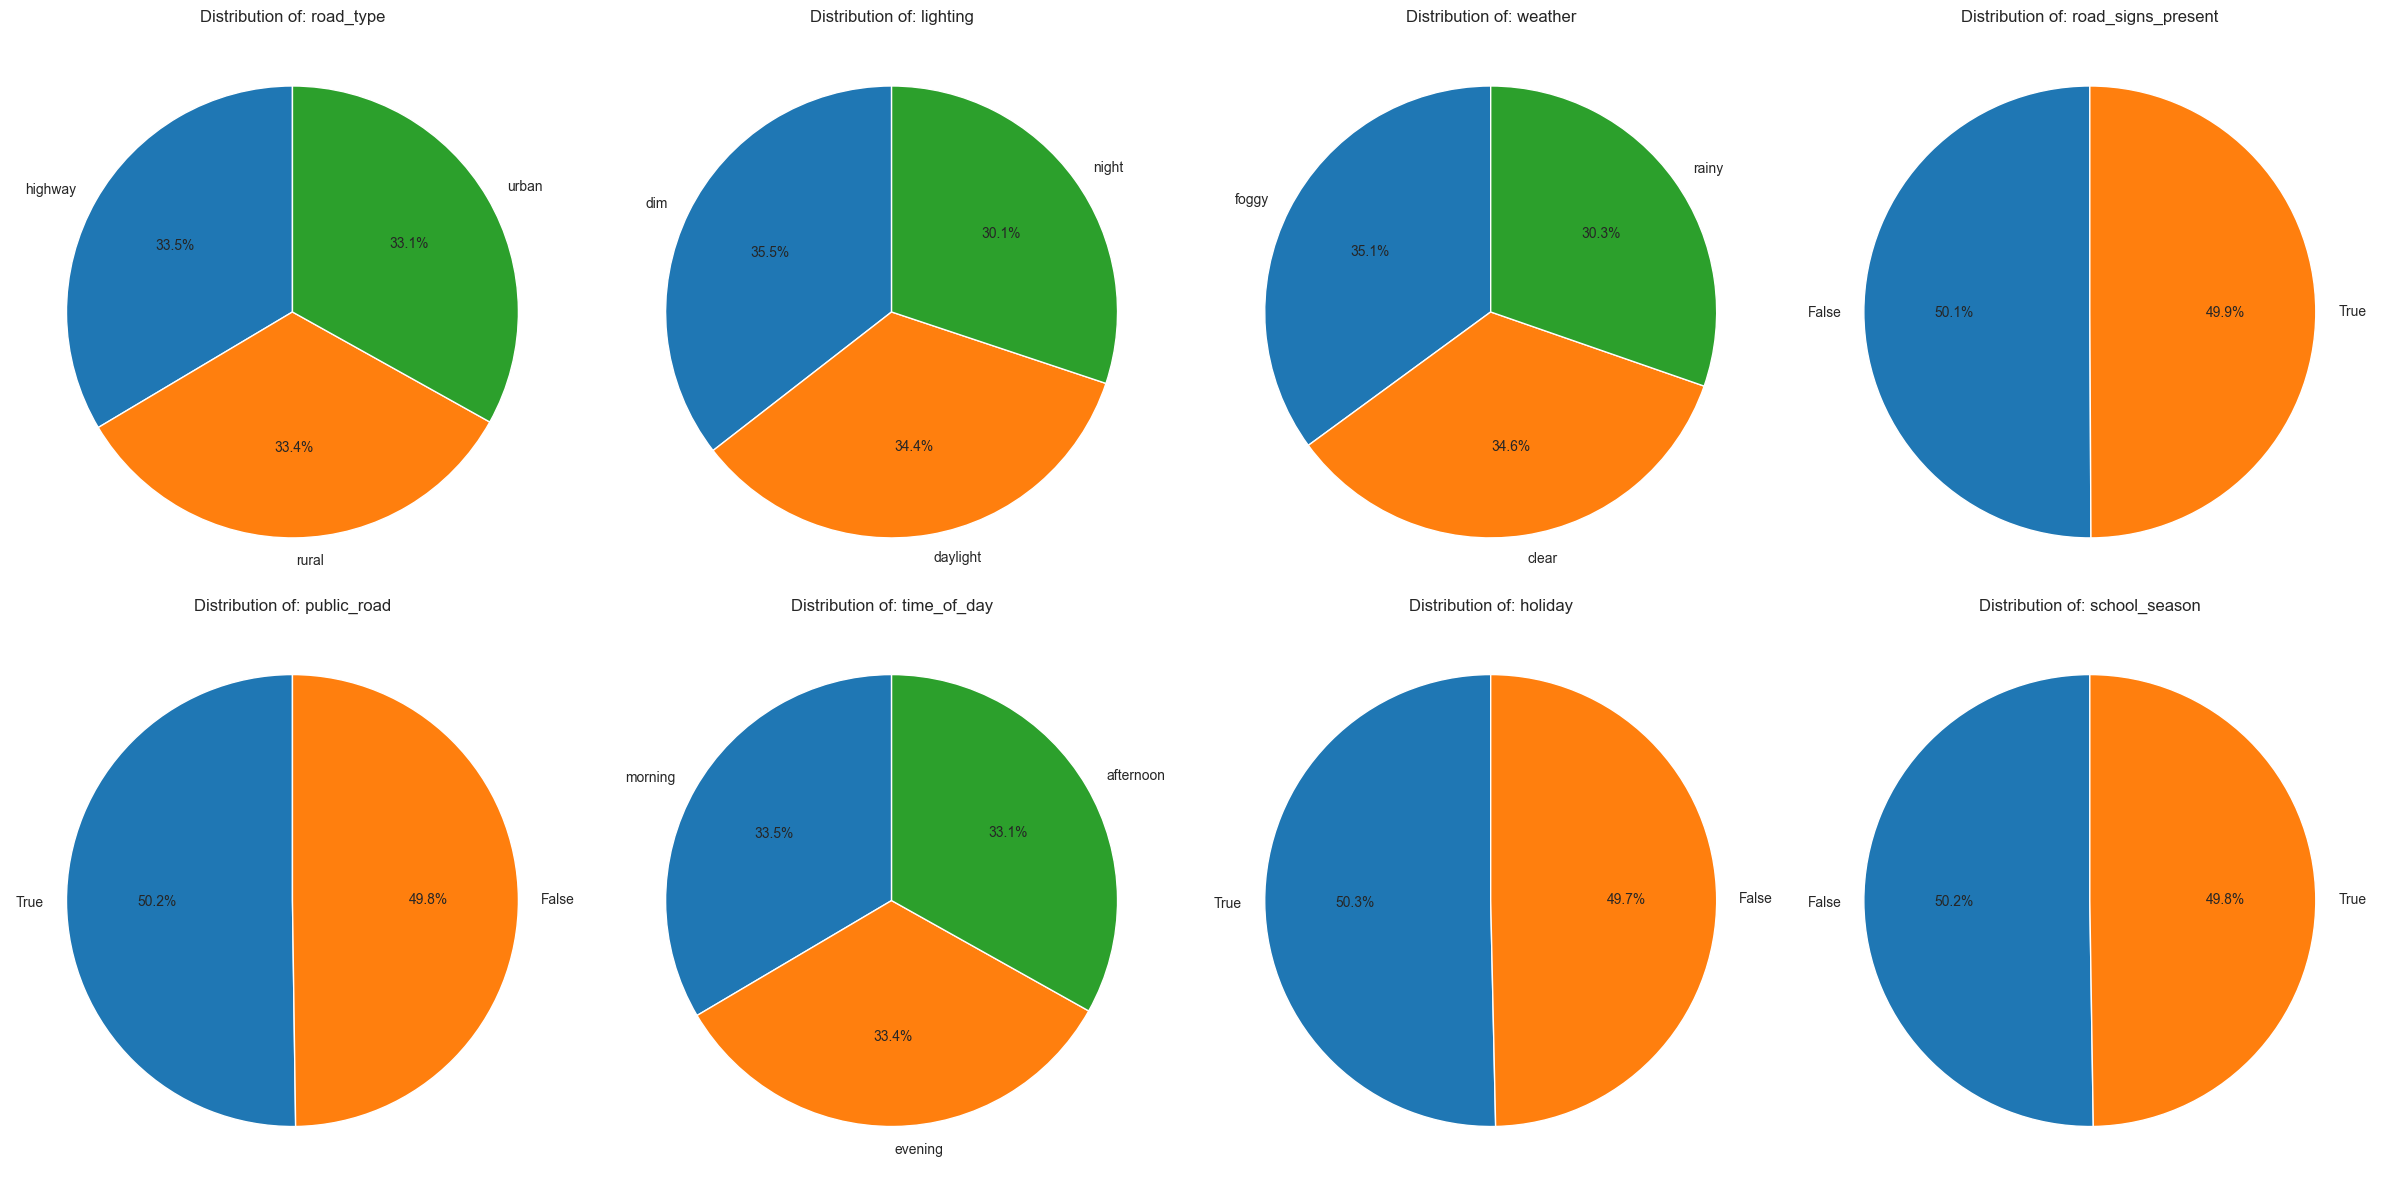

In [23]:
def plot_cat_cols_pie_grid(df, cat_cols, cols=3):
    """
    Draws pie charts for all categorical columns in one grid.
    
    Parameters:
        df (DataFrame): The dataframe.
        cat_cols (list): List of categorical column names.
        cols (int): Number of subplots per row.
    """
    
    n = len(cat_cols)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows))
    axes = axes.flatten()  # flatten for easy indexing

    for i, col in enumerate(cat_cols):
        counts = df[col].value_counts()

        axes[i].pie(
            counts.values,
            labels=counts.index,
            autopct='%1.1f%%',
            startangle=90
        )
        axes[i].set_title(f"Distribution of: {col}")
        axes[i].set_ylabel("")

    # Hide empty subplot spaces
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
plot_cat_cols_pie_grid(df, cat_cols_train, cols=4)

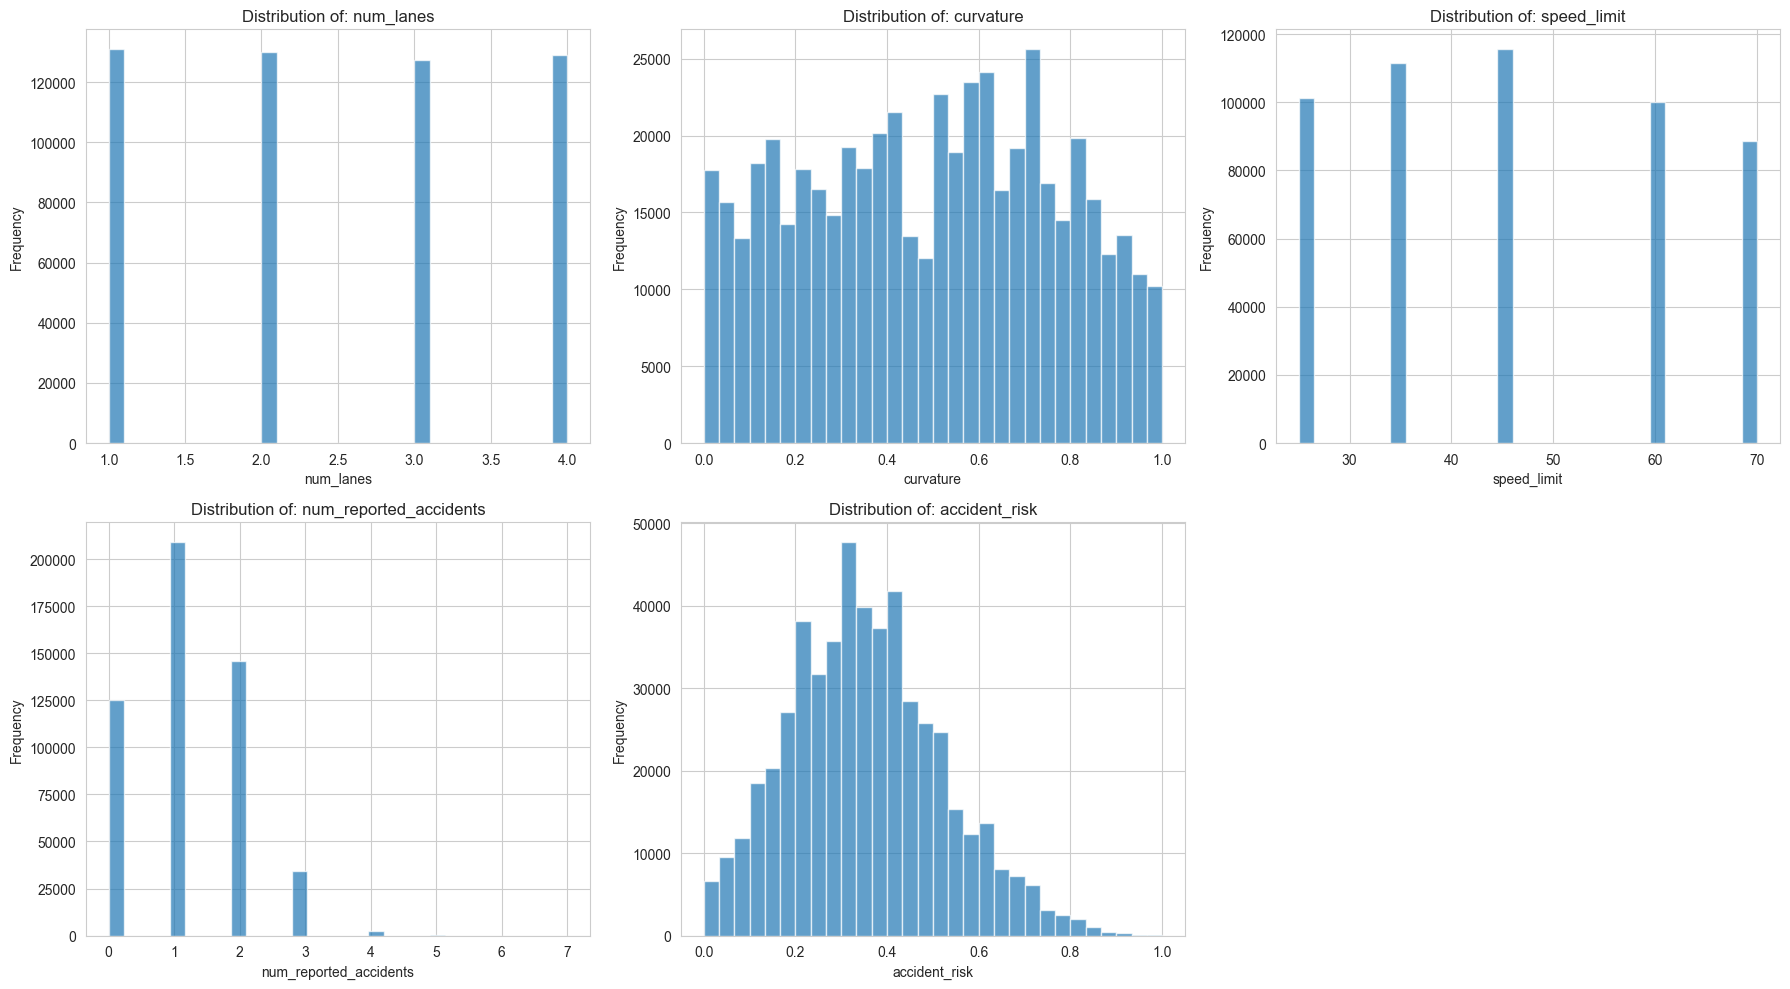

In [24]:
# distribution of numerical columns 
def plot_num_cols_distribution(df, num_cols, cols=3):
    """
    Plots histograms for all numerical columns in one grid.

    Parameters:
        df (DataFrame): Dataset
        num_cols (list): Numerical column names
        cols (int): Number of subplots per row
    """

    n = len(num_cols)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        axes[i].hist(
            df[col].dropna(),
            bins=30,
            alpha=0.7
        )
        axes[i].set_title(f"Distribution of: {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")

    # Hide empty plots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_num_cols_distribution(df, num_cols_train, cols=3)

#### i note that the num_lanes, speed_limit, num_reported_accidents have limited values 

In [25]:
for col in ['num_lanes', 'speed_limit', 'num_reported_accidents']:
    counts = df[col].value_counts()
    perc = df[col].value_counts(normalize=True) * 100
    
    summary = pd.DataFrame({'Count': counts, 'Percentage %': perc.round(2)})
    print(f"\n=== {col} ===")
    print(summary)


=== num_lanes ===
            Count  Percentage %
num_lanes                      
1          131002         25.33
2          129901         25.12
4          128937         24.93
3          127258         24.61

=== speed_limit ===
              Count  Percentage %
speed_limit                      
45           115588         22.35
35           111493         21.56
25           101291         19.59
60           100184         19.37
70            88542         17.12

=== num_reported_accidents ===
                         Count  Percentage %
num_reported_accidents                      
1                       209335         40.48
2                       145801         28.20
0                       125138         24.20
3                        34176          6.61
4                         2391          0.46
5                          231          0.04
6                           24          0.00
7                            2          0.00


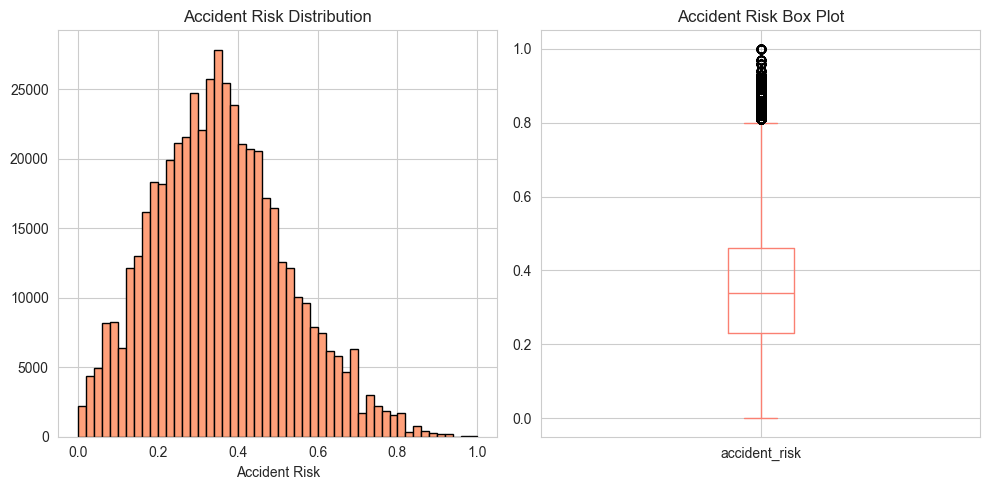

In [26]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['accident_risk'], bins=50, edgecolor='black', color='lightsalmon')
plt.title('Accident Risk Distribution')
plt.xlabel('Accident Risk')

plt.subplot(1, 2, 2)
df['accident_risk'].plot(kind='box', color='salmon')
plt.title('Accident Risk Box Plot')
plt.tight_layout()
plt.show()

### Bivariate Analysis

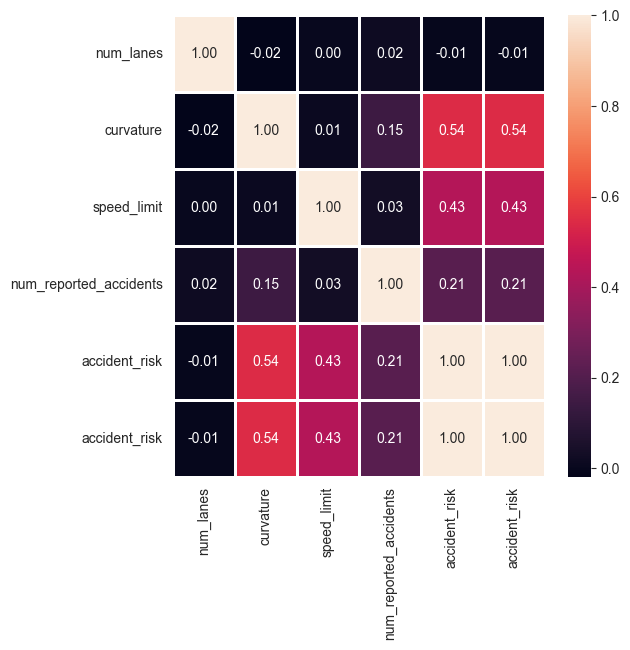

In [27]:
# numerical features correlation
plt.figure(figsize=(6, 6))
correlation_matrix = df[num_cols_train + ['accident_risk']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
            linewidths=1, color="blue")
plt.show()

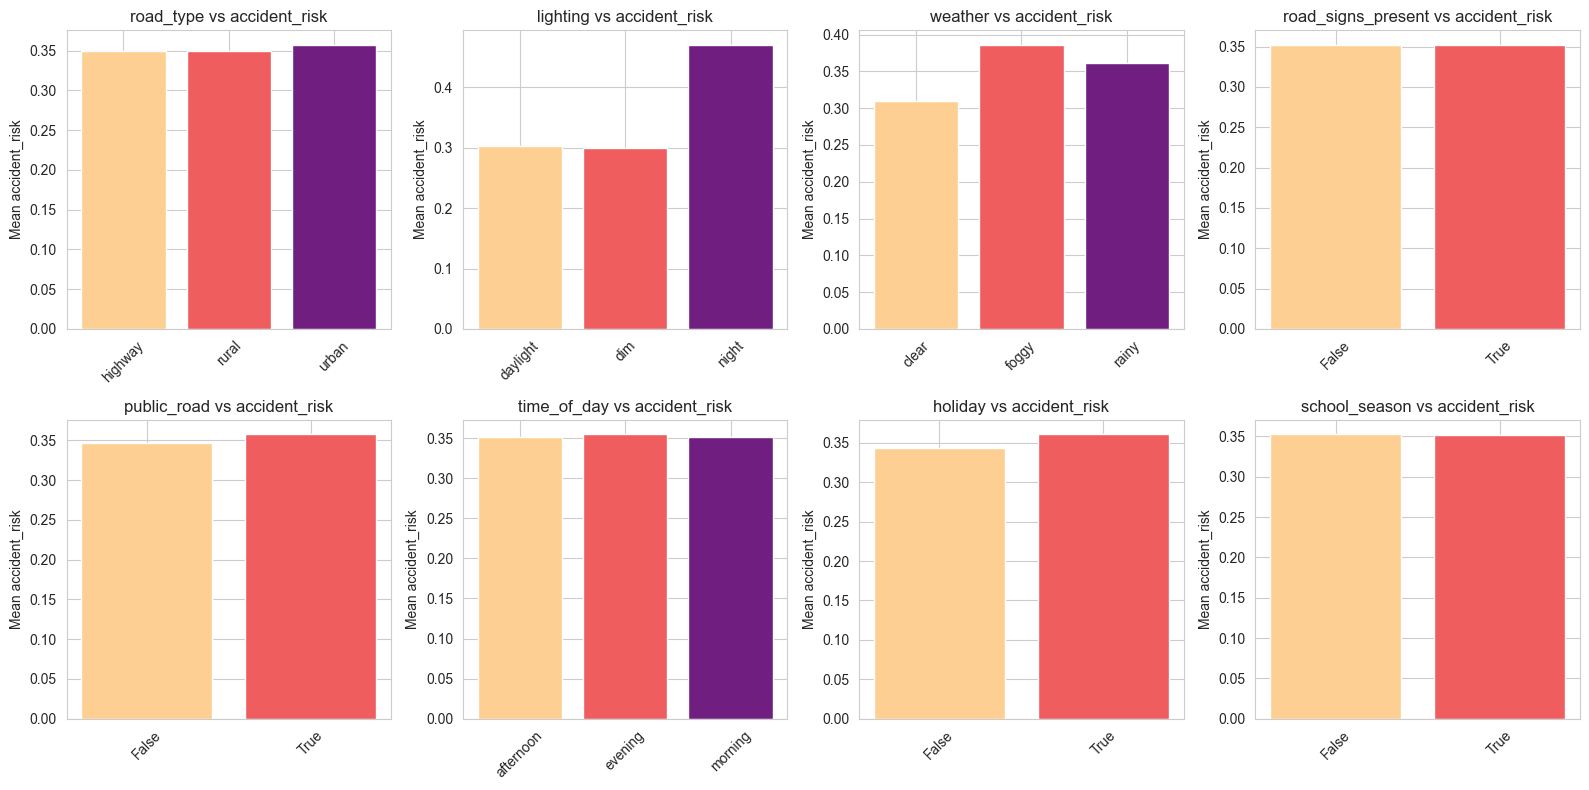

In [28]:
# Categorical features vs target

fig , axes = plt.subplots(2,4, figsize=(16,8))
axes = axes.flatten()
cmap = plt.get_cmap('magma')
colors = cmap([0.9,0.66,0.33])
target = 'accident_risk'
for i,col in enumerate(cat_cols_train) :
  
    grouped = df.groupby(col)[target].mean()
   
    axes[i].bar(grouped.index.astype(str), grouped.values , color=colors)  # .astype(str) to handle non-string indices
    
    axes[i].set_ylabel(f'Mean {target}')
    axes[i].set_title(f'{col} vs {target}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [29]:
# split data into features and target
X = df.drop('accident_risk', axis=1)
y = df['accident_risk']

In [30]:
# identify columns 
# categorical columns
cat = X.select_dtypes(exclude=[np.number]).columns
# numerical columns
num = X.select_dtypes(include=[np.number]).columns

In [31]:
# numerical pipeline 
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [32]:
# categorical pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # or use OrdinalEncoder()
])

In [33]:
# column transformation
processor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, num),  
        ('cat_pipeline', cat_pipeline, cat)  
    ]
)

In [34]:
# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y)

In [35]:
# apply transformations
processor.fit(x_train)

x_train_processed = processor.transform(x_train)
x_test_processed = processor.transform(x_test)

In [36]:
x_train_processed.shape

(413678, 24)

In [37]:
# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

In [38]:
# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Fit the model
    model.fit(x_train_processed, y_train)
    
    # Make predictions
    y_train_pred = model.predict(x_train_processed)
    y_test_pred = model.predict(x_test_processed)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Store results
    results[name] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae
    }
    
# Print results
print(f"  Train RMSE: {train_rmse:.4f}")
print(f"  Test RMSE:  {test_rmse:.4f}")
print(f"  Train R²:   {train_r2:.4f}")
print(f"  Test R²:    {test_r2:.4f}")
print(f"  Test MAE:   {test_mae:.4f}")

# Compare models
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('test_r2', ascending=False)
print(results_df)

# Find best model
best_model_name = results_df['test_r2'].idxmax()
print(f"\nBest Model: {best_model_name}")
print(f"Test R² Score: {results_df.loc[best_model_name, 'test_r2']:.4f}")


Training Linear Regression...

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...
  Train RMSE: 0.0553
  Test RMSE:  0.0562
  Train R²:   0.8894
  Test R²:    0.8861
  Test MAE:   0.0436

MODEL COMPARISON
                   train_rmse  test_rmse  train_r2   test_r2  test_mae
XGBoost              0.055336   0.056159  0.889442  0.886115  0.043632
Gradient Boosting    0.056894   0.056827  0.883128  0.883391  0.044303
Random Forest        0.022951   0.059423  0.980982  0.872494  0.046230
Linear Regression    0.073514   0.073486  0.804870  0.805002  0.058419

Best Model: XGBoost
Test R² Score: 0.8861


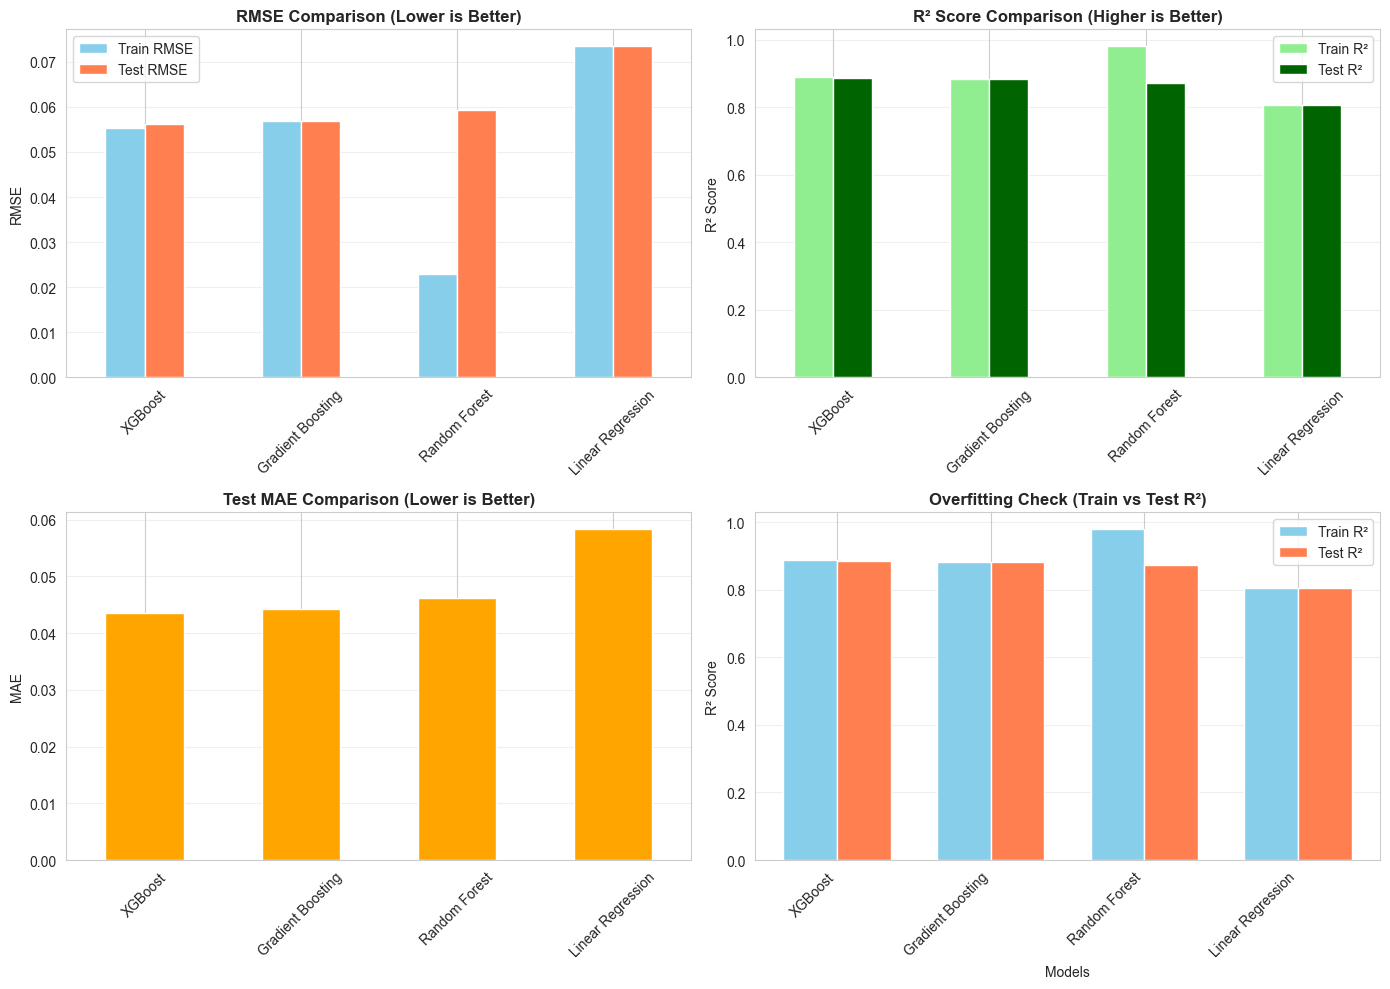

In [39]:
# 1. Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE Comparison
results_df[['train_rmse', 'test_rmse']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'coral'])
axes[0, 0].set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].legend(['Train RMSE', 'Test RMSE'])
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# R² Comparison
results_df[['train_r2', 'test_r2']].plot(kind='bar', ax=axes[0, 1], color=['lightgreen', 'darkgreen'])
axes[0, 1].set_title('R² Score Comparison (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].legend(['Train R²', 'Test R²'])
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# MAE Comparison
results_df['test_mae'].plot(kind='bar', ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Test MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Overfitting Check (Train vs Test R²)
model_names = results_df.index
x_pos = np.arange(len(model_names))
width = 0.35

axes[1, 1].bar(x_pos - width/2, results_df['train_r2'], width, label='Train R²', color='skyblue')
axes[1, 1].bar(x_pos + width/2, results_df['test_r2'], width, label='Test R²', color='coral')
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Overfitting Check (Train vs Test R²)', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

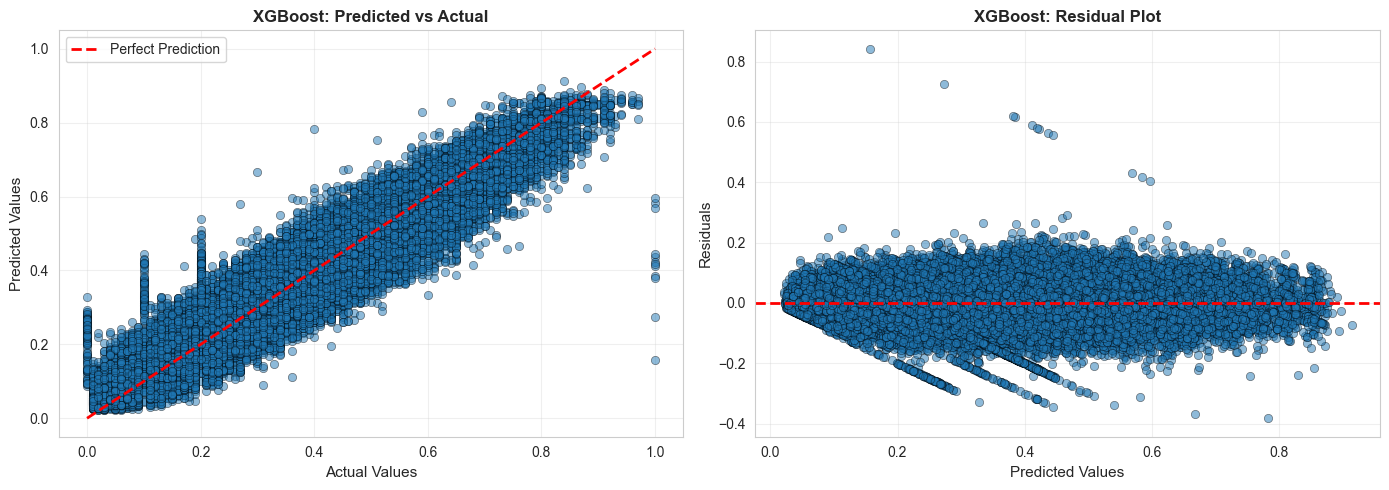

In [40]:
# 2. Predictions vs Actual for Best Model
best_model = models[best_model_name]
y_pred_best = best_model.predict(x_test_processed)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_best, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values', fontsize=11)
axes[0].set_ylabel('Predicted Values', fontsize=11)
axes[0].set_title(f'{best_model_name}: Predicted vs Actual', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals plot
residuals = y_test - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Values', fontsize=11)
axes[1].set_ylabel('Residuals', fontsize=11)
axes[1].set_title(f'{best_model_name}: Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

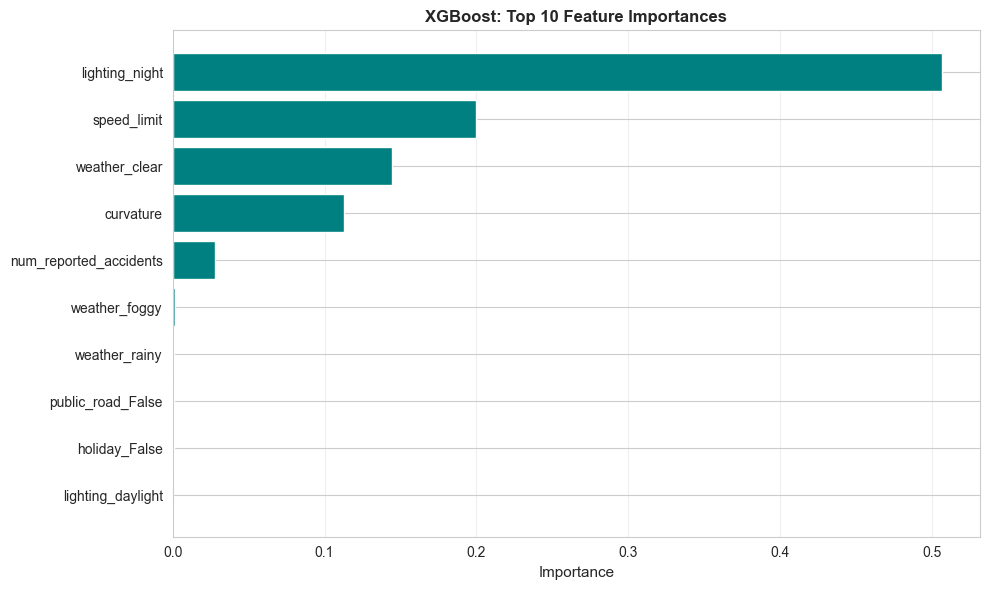

In [41]:
# 3. Feature Importance (if applicable)
if hasattr(best_model, 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = []
    
    # Numerical features
    if hasattr(processor.named_transformers_['num_pipeline'], 'get_feature_names_out'):
        feature_names.extend(processor.named_transformers_['num_pipeline'].get_feature_names_out())
    else:
        feature_names.extend(num)  # Use original numerical column names
    
    # Categorical features (after one-hot encoding)
    if hasattr(processor.named_transformers_['cat_pipeline'], 'get_feature_names_out'):
        feature_names.extend(processor.named_transformers_['cat_pipeline'].get_feature_names_out())
    
    # Plot feature importance
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]  # Top 20 features
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], color='teal')
    plt.yticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f'Feature {i}' for i in indices])
    plt.xlabel('Importance', fontsize=11)
    plt.title(f'{best_model_name}: Top 10 Feature Importances', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"\n{best_model_name} does not have feature_importances_ attribute")

In [42]:
# save the best model pkl ,joblib
import joblib
joblib.dump(best_model, '../models/best_model.joblib')

import pickle
with open('../models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Model saved successfully.")

Model saved successfully.
